In [1]:
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from jupyterplot import ProgressPlot

from nn_sim.data import DataLoader, DatasetNN
from nn_sim.net import layers as nn_layers
from nn_sim.net.layers import (
    Module, Sigmoid, ReLU, IdentityActivation, 
    Step, Softmax, SSELoss, MSELoss, MAELoss, BinaryCrossEntropyLoss,
    CategoricalCrossEntropyLoss,
    HiddenLayer,)
from nn_sim.net.feedfoward import FeedFowardNeuralNetwork

from nn_sim.net import metrics

## Generate dataset

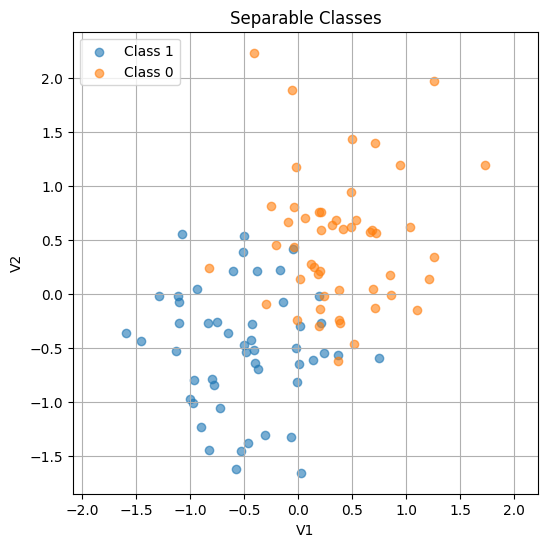

In [2]:
# Parameters for the first set of points
num_points_1 = 50
x_center_1 = -0.5
y_center_1 = -0.5
sigma_1 = 0.55

# Parameters for the second set of points
num_points_2 = 50
x_center_2 = 0.5
y_center_2 = 0.5
sigma_2 = 0.55

# Generating the first set of random points
v1_c1 = np.random.normal(x_center_1, sigma_1, num_points_1)
v2_c1 = np.random.normal(y_center_1, sigma_1, num_points_1)
points_1 = np.column_stack((v1_c1, v2_c1))

# Generating the second set of random points
v1_c2 = np.random.normal(x_center_2, sigma_2, num_points_2)
v2_c2 = np.random.normal(y_center_2, sigma_2, num_points_2)
points_2 = np.column_stack((v1_c2, v2_c2))

# Plotting
plt.figure(figsize=(6, 6))
plt.scatter(points_1[:, 0], points_1[:, 1], alpha=0.6, label='Class 1')
plt.scatter(points_2[:, 0], points_2[:, 1], alpha=0.6, label='Class 0')
plt.title('Separable Classes')
plt.xlabel('V1')
plt.ylabel('V2')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

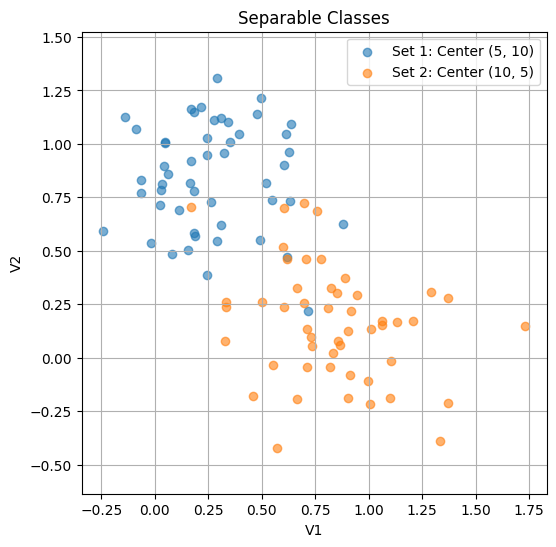

In [3]:
# Parameters for the first set of points
num_points_1 = 50
x_center_1 = 0.25
y_center_1 = 0.8
sigma_1 = 0.25

# Parameters for the second set of points
num_points_2 = 50
x_center_2 = 0.9
y_center_2 = 0.2
sigma_2 = 0.25

# Generating the first set of random points
v1_c1 = np.random.normal(x_center_1, sigma_1, num_points_1)
v2_c1 = np.random.normal(y_center_1, sigma_1, num_points_1)
points_1 = np.column_stack((v1_c1, v2_c1)).astype(np.float32)

# Generating the second set of random points
v1_c2 = np.random.normal(x_center_2, sigma_2, num_points_2)
v2_c2 = np.random.normal(y_center_2, sigma_2, num_points_2)
points_2 = np.column_stack((v1_c2, v2_c2)).astype(np.float32)

# Plotting
plt.figure(figsize=(6, 6))
plt.scatter(points_1[:, 0], points_1[:, 1], alpha=0.6, label='Set 1: Center (5, 10)')
plt.scatter(points_2[:, 0], points_2[:, 1], alpha=0.6, label='Set 2: Center (10, 5)')
plt.title('Separable Classes')
plt.xlabel('V1')
plt.ylabel('V2')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

## Gradient Descent

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:02<00:00, 4261.96it/s]


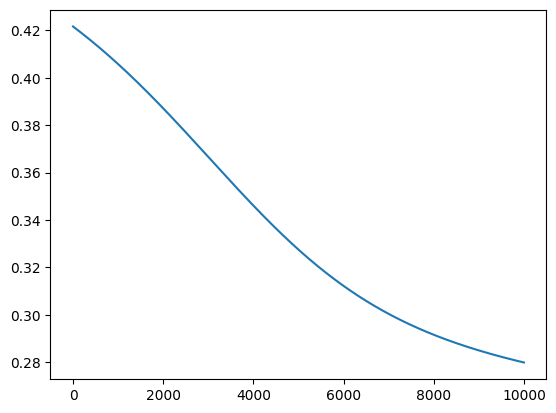

In [4]:
net = FeedFowardNeuralNetwork(
    2, 
    [
        (5, True, Sigmoid()),
        (5, True, Sigmoid()),
        (1, True, Sigmoid()),
    ]
)

X = np.vstack((points_1, points_2))
Y = np.vstack((np.zeros((points_1.shape[0], 1), dtype=np.float32),
               np.ones((points_2.shape[0], 1), dtype=np.float32),))


loss_func = MSELoss()
learning_rate = 0.2
MAX_EPOCHS = 10000

losses = list()

for epoch in tqdm(range(MAX_EPOCHS)):
    
    net.zero_gradients()
    
    y_pred = net(X)
    loss = loss_func(y_pred, Y)
    
    losses.append(loss)
    
    net.backward(y_pred, Y, loss_func)
    
    for layer in net.layers:
        layer.weights = layer.weights - learning_rate * layer.grad_weights
        layer.bias = layer.bias - learning_rate * layer.grad_bias

plt.plot(losses)
plt.show()

## Gradient Descent With Momentum

100%|██████████| 20000/20000 [00:05<00:00, 3982.79it/s]


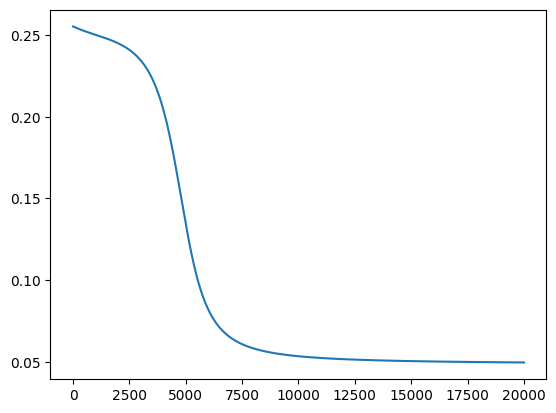

0.04960145004010242


In [5]:
net = FeedFowardNeuralNetwork(
    2, 
    [
        (5, True, Sigmoid()),
        (5, True, Sigmoid()),
        (1, True, Sigmoid()),
    ]
)

for layer in net.layers:
    layer.velocity_weights = np.zeros_like(layer.weights)
    layer.velocity_bias = np.zeros_like(layer.bias)

X = np.vstack((points_1, points_2))
Y = np.vstack((np.zeros((points_1.shape[0], 1), dtype=np.float32),
               np.ones((points_2.shape[0], 1), dtype=np.float32),))


loss_func = MSELoss()
learning_rate = 0.2
momentum = 0.95  # Common values are between 0.9 and 0.99
MAX_EPOCHS = 20000

losses = list()

for epoch in tqdm(range(MAX_EPOCHS)):
    
    net.zero_gradients()
    
    y_pred = net(X)
    loss = loss_func(y_pred, Y)
    losses.append(loss)
    
    net.backward(y_pred, Y, loss_func)
    
    for layer in net.layers:
        # Update velocities
        layer.velocity_weights = momentum * layer.velocity_weights + learning_rate * layer.grad_weights
        layer.velocity_bias = momentum * layer.velocity_bias + learning_rate * layer.grad_bias

        # Update parameters
        layer.weights = layer.weights - layer.velocity_weights
        layer.bias = layer.bias - layer.velocity_bias

plt.plot(losses)
plt.show()
print(loss)

## ADAM

100%|██████████| 20000/20000 [00:17<00:00, 1157.34it/s]


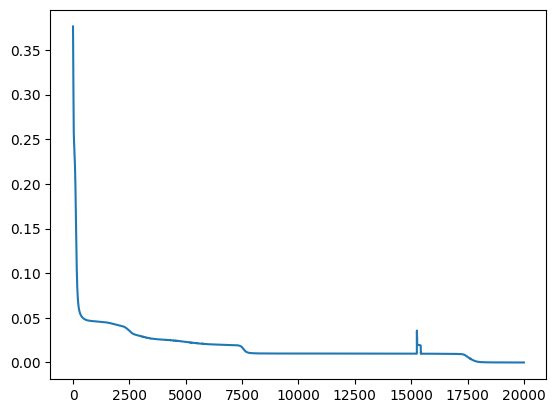

1.785142775044304e-05


In [6]:
net = FeedFowardNeuralNetwork(
    2, 
    [
        (16, True, Sigmoid()),
        (16, True, Sigmoid()),
        (16, True, Sigmoid()),
        (16, True, Sigmoid()),
        (16, True, Sigmoid()),
        (16, True, Sigmoid()),
        (1, True, Sigmoid()),
    ]
)

for layer in net.layers:
    layer.m_weights = np.zeros_like(layer.weights)
    layer.v_weights = np.zeros_like(layer.weights)
    layer.m_bias = np.zeros_like(layer.bias)
    layer.v_bias = np.zeros_like(layer.bias)

X = np.vstack((points_1, points_2))
Y = np.vstack((np.zeros((points_1.shape[0], 1), dtype=np.float32),
               np.ones((points_2.shape[0], 1), dtype=np.float32),))


beta1 = 0.8
beta2 = 0.999
epsilon = 1e-7

loss_func = MSELoss()
learning_rate = 0.001
MAX_EPOCHS = 20000

losses = list()

for epoch in tqdm(range(MAX_EPOCHS)):
    
    net.zero_gradients()
    
    y_pred = net(X)
    loss = loss_func(y_pred, Y)
    losses.append(loss)
    
    net.backward(y_pred, Y, loss_func)
    
    t = epoch + 1  # timestep used for bias correction
    
    for layer in net.layers:
        # Update first moment estimate
        layer.m_weights = beta1 * layer.m_weights + (1 - beta1) * layer.grad_weights
        layer.m_bias = beta1 * layer.m_bias + (1 - beta1) * layer.grad_bias
        
        # Update second moment estimate
        layer.v_weights = beta2 * layer.v_weights + (1 - beta2) * (layer.grad_weights ** 2)
        layer.v_bias = beta2 * layer.v_bias + (1 - beta2) * (layer.grad_bias ** 2)
        
        # Compute bias-corrected first and second moment estimates
        m_hat_weights = layer.m_weights / (1 - beta1 ** t)
        m_hat_bias = layer.m_bias / (1 - beta1 ** t)
        v_hat_weights = layer.v_weights / (1 - beta2 ** t)
        v_hat_bias = layer.v_bias / (1 - beta2 ** t)
        
        # Update parameters
        layer.weights -= learning_rate * m_hat_weights / (np.sqrt(v_hat_weights) + epsilon)
        layer.bias -= learning_rate * m_hat_bias / (np.sqrt(v_hat_bias) + epsilon)
    
plt.plot(losses)
plt.show()
print(loss)

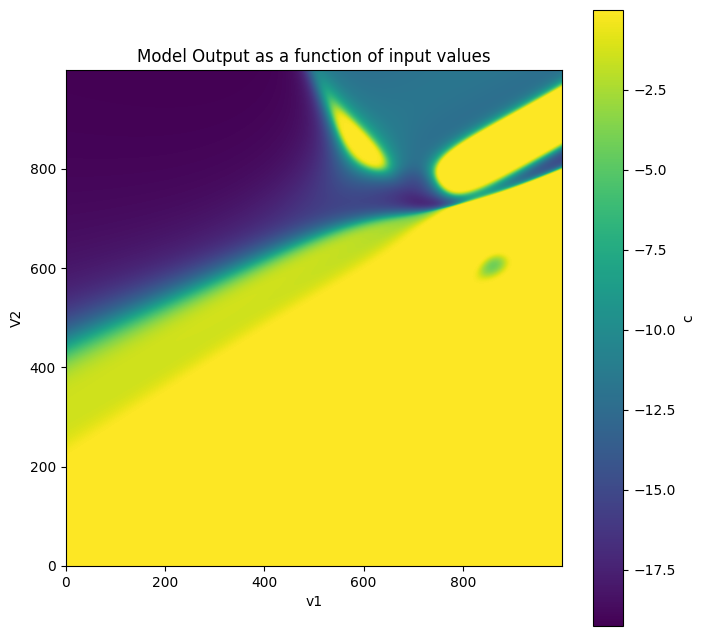

In [7]:
resolution = 1
grid_x, grid_y = np.meshgrid(np.linspace(-1, 1, 1000), np.linspace(-1, 1, 1000))
input_grid = np.column_stack([grid_x.flatten(), grid_y.flatten()])  # Flatten the grid for processing

predictions = net(input_grid)

predictions = np.array(predictions).reshape((1000, 1000))

# Plot the heatmap
plt.figure(figsize=(8, 8))
plt.imshow(np.log(predictions), origin='lower', cmap='viridis')
plt.colorbar(label='c')
plt.xlabel('v1')
plt.ylabel('V2')
plt.title('Model Output as a function of input values')
plt.show()

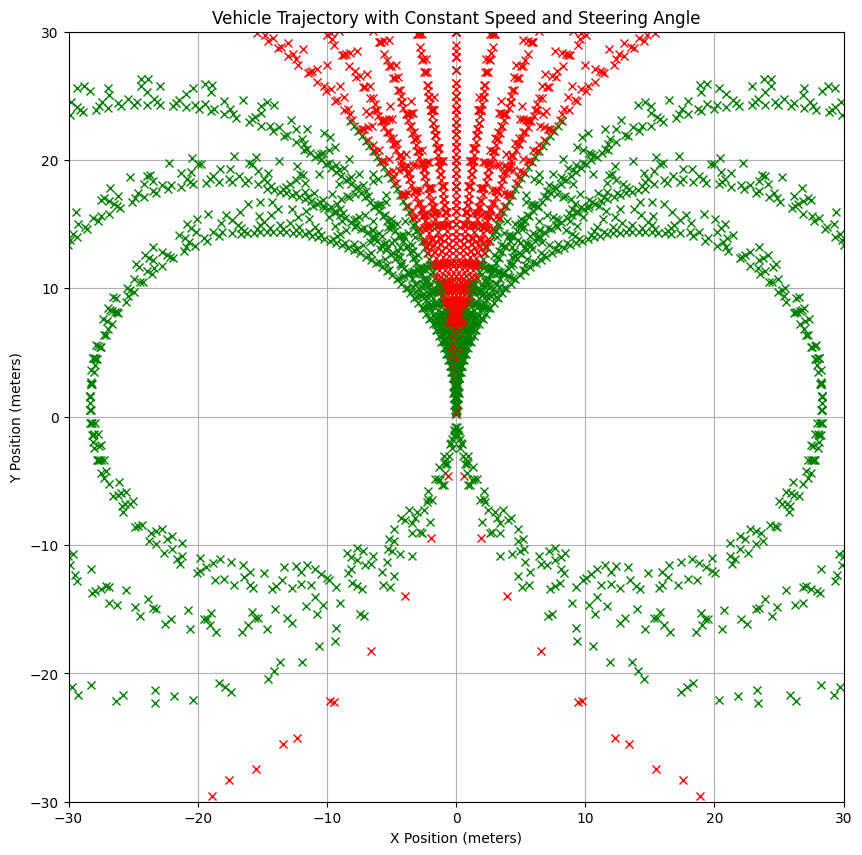

In [8]:
import numpy as np
import matplotlib.pyplot as plt


curves = list()

L = 2.5  # wheelbase of the vehicle (distance between front and rear axle)
# Simulation settings
dt = 0.1  # time step in seconds
total_time = 5  # total simulation time in seconds
timesteps = np.arange(0, total_time, dt)

opponent_x = 20
opponent_y = 0

dataset = list()

for speed in [5, 10, 15, 20, 30, 40, 50]:
  for angle in [-10, -8, -6, -4, -3, -2, -1, 0, 1, 2, 3, 4, 6, 8, 10]:

    collision = 0

    steering_angle = np.deg2rad(angle)  # steering angle in radians

    # Initialize state variables
    x = 0.0  # initial x position
    y = 0.0  # initial y position
    theta = 0.0  # initial heading direction (facing along the x-axis)

    # Time vector for simulation
    x_positions = []
    y_positions = []

    # Simulation loop
    for t in timesteps:
        # Update the vehicle's state
        x += speed * np.cos(theta) * dt
        y += speed * np.sin(theta) * dt
        theta += speed * np.tan(steering_angle) / L * dt

        # Store positions for plotting
        x_positions.append(x)
        y_positions.append(y)

        dx = opponent_x - x
        dy = opponent_y - y
        dist = np.sqrt(dx*dx + dy*dy)

        if dist < 5.0:
          collision = 1

    dataset.append((speed, angle, collision))
    curves.append((y_positions, x_positions))

# Plotting the trajectory
plt.figure(figsize=(10, 10))

N = len(dataset)

for idx in range(N):
  speed, angle, collision = dataset[idx]
  x_positions, y_positions = curves[idx]

  if collision == 1:
    plt.plot(x_positions, y_positions, 'x', color='r', label='Trajectory')
  else:
    plt.plot(x_positions, y_positions, 'x', color='g', label='Trajectory')

plt.title('Vehicle Trajectory with Constant Speed and Steering Angle')
plt.xlabel('X Position (meters)')
plt.ylabel('Y Position (meters)')
plt.grid(True)
plt.xlim([-30, 30])
plt.ylim([-30, 30])
plt.show()


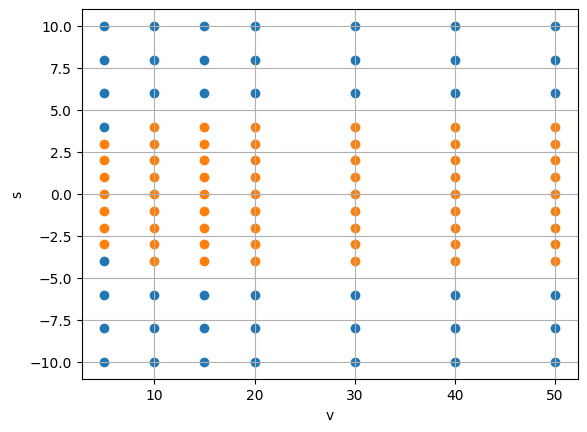

In [9]:
V0 = list()
S0 = list()

V1 = list()
S1 = list()

color = list()
X = list()
Y = list()
for idx in range(len(dataset)):
    v, s, t = dataset[idx]
    X.append((v,s))
    Y.append((t,))

    if t == 0:
      V0.append(v)
      S0.append(s)
    else:
      V1.append(v)
      S1.append(s)

X = np.array(X)
Y = np.array(Y)

plt.scatter(V0, S0)
plt.scatter(V1, S1)
plt.grid(True)
plt.xlabel('v')
plt.ylabel('s')
plt.show()

100%|██████████| 10000/10000 [00:13<00:00, 753.54it/s]


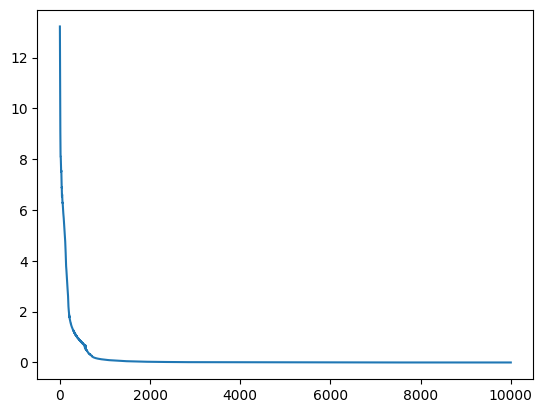

loss 0.00011277321936475058


{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}

In [10]:
net = FeedFowardNeuralNetwork(
    2, 
    [
        (64, True, ReLU()),
        (64, True, Sigmoid()),
        (64, True, ReLU()),
        (1, True, Sigmoid()),
    ]
)

for layer in net.layers:
    layer.m_weights = np.zeros_like(layer.weights)
    layer.v_weights = np.zeros_like(layer.weights)
    layer.m_bias = np.zeros_like(layer.bias)
    layer.v_bias = np.zeros_like(layer.bias)


beta1 = 0.9
beta2 = 0.999
epsilon = 1e-7

loss_func = BinaryCrossEntropyLoss()
# loss_func = MSELoss()
learning_rate = 0.001
MAX_EPOCHS = 10000

losses = list()

for epoch in tqdm(range(MAX_EPOCHS)):
    
    net.zero_gradients()
    
    y_pred = net(X)
    loss = loss_func(Y, y_pred)
    losses.append(loss)
    
    net.backward(y_pred, Y, loss_func)
    
    t = epoch + 1  # timestep used for bias correction
    
    for layer in net.layers:
        # Update first moment estimate
        layer.m_weights = beta1 * layer.m_weights + (1 - beta1) * layer.grad_weights
        layer.m_bias = beta1 * layer.m_bias + (1 - beta1) * layer.grad_bias
        
        # Update second moment estimate
        layer.v_weights = beta2 * layer.v_weights + (1 - beta2) * (layer.grad_weights ** 2)
        layer.v_bias = beta2 * layer.v_bias + (1 - beta2) * (layer.grad_bias ** 2)
        
        # Compute bias-corrected first and second moment estimates
        m_hat_weights = layer.m_weights / (1 - beta1 ** t)
        m_hat_bias = layer.m_bias / (1 - beta1 ** t)
        v_hat_weights = layer.v_weights / (1 - beta2 ** t)
        v_hat_bias = layer.v_bias / (1 - beta2 ** t)
        
        # Update parameters
        layer.weights -= learning_rate * m_hat_weights / (np.sqrt(v_hat_weights) + epsilon)
        layer.bias -= learning_rate * m_hat_bias / (np.sqrt(v_hat_bias) + epsilon)

plt.plot(losses)
plt.show()
print("loss", loss)

y_pred = net(X)
metrics.compute_classification_metrics(Y, y_pred)

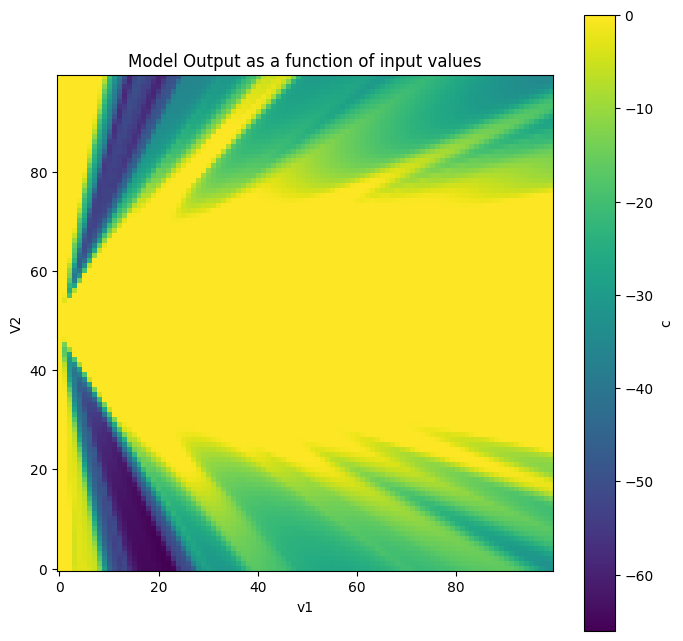

In [12]:
grid_x, grid_y = np.meshgrid(np.linspace(0, 50, 100), np.linspace(-10, 10, 100))
input_grid = np.column_stack([grid_x.flatten(), grid_y.flatten()])

predictions = net(input_grid)

predictions = np.array(predictions).reshape((100, 100)) 

# Plot the heatmap
plt.figure(figsize=(8, 8))
plt.imshow(np.log(predictions), origin='lower', cmap='viridis')
plt.colorbar(label='c')
plt.xlabel('v1')
plt.ylabel('V2')
plt.title('Model Output as a function of input values')
plt.show()